https://towardsdatascience.com/decision-tree-algorithm-for-multiclass-problems-using-python-6b0ec1183bf5

https://scikit-learn.org/stable/modules/tree.html

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import graphviz 
from sklearn import tree

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')
data.head(5)

weight  height  closing  open_00_01  open_01_02  open_02_03  open_03_04  \
0      69    1.77       12           0           0           0           0   
1      69    1.77       24           1           1           1           1   
2      69    1.77       20           0           0           0           0   
3      69    1.77       23           0           0           0           0   
4      69    1.77       23           0           0           0           0   

   open_04_05  open_05_06  open_06_07  ...  cuisine_y_Pizzeria  \
0           0           0           0  ...                   0   
1           1           1           1  ...                   0   
2           0           0           0  ...                   0   
3           0           0           0  ...                   0   
4           0           0           0  ...                   0   

   cuisine_y_Regional  cuisine_y_Seafood  cuisine_y_Vietnamese  \
0                   0                  0                     0   
1                   0                  0                     0   
2                   0                  1                     0   
3                   0                  0                     0   
4                   0                  0                     0   

   parking_lot_none  parking_lot_public  parking_lot_valet parking  \
0                 1                   0                          0   
1                 0                   1                          0   
2                 0                   0                          0   
3                 1                   0                          0   
4                 1                   0                          0   

   parking_lot_yes  age  target  
0                0   32       2  
1                0   32       0  
2                1   32       1  
3                0   32       2  
4                0   32       2  

[5 rows x 151 columns]

In [3]:
def split_data(data_x: np.ndarray, data_y: np.ndarray):
    
    ordering = np.arange(data_x.shape[0])
    np.random.shuffle(ordering)
    data_x = data_x[ordering]
    data_y = data_y[ordering]
    
    valid_start = int(len(data_x) * 0.7)
    test_start = int(len(data_x) * 0.9)
    
    train_set = (data_x[:valid_start], data_y[:valid_start])
    valid_set = (data_x[valid_start:test_start], data_y[valid_start:test_start])
    test_set = (data_x[test_start:], data_y[test_start:])
    
    return train_set, valid_set, test_set

In [4]:
y = np.array(data['target'])
x = np.array(data.drop(['target'], axis=1))

train_set, valid_set, test_set = split_data(x,y)

x_train = train_set[0]
y_train = train_set[1]

x_val = valid_set[0]
y_val = valid_set[1]

x_test = test_set[0]
y_test = test_set[1]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(2073, 150)
(592, 150)
(297, 150)


## One tree to go 

In [5]:
n=24
depth_arr = np.linspace(2, 25, 24)
train_accuracy = np.zeros(n)
val_accuracy = np.zeros(n)

for ind, depth in enumerate(depth_arr):    
    
    clf = tree.DecisionTreeClassifier(max_depth=depth, criterion='entropy', splitter='best')
    clf = clf.fit(x_train, y_train)

    
    output = clf.predict(x_train)
    target = y_train
    train_accuracy[ind] =sum(output == target)/ len(target)
    
    output = clf.predict(x_val)
    target = y_val
    val_accuracy[ind] =sum(output == target)/ len(target)

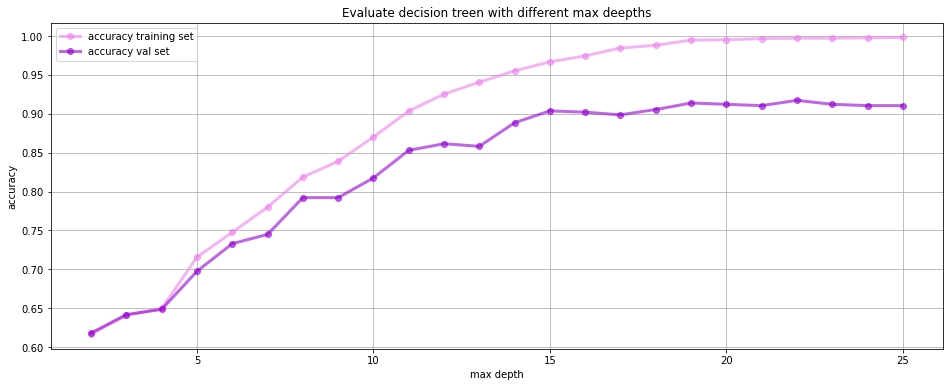

In [6]:
# Plotting
plt.figure(figsize=(16, 6))

plt.plot(depth_arr, train_accuracy, 'bo-', label=r'accuracy training set', color="violet", alpha=0.6, linewidth=3)
plt.plot(depth_arr, val_accuracy, 'bo-', label=r'accuracy val set', color="darkviolet", alpha=0.6, linewidth=3)

plt.xlabel('max depth'); plt.ylabel(r'accuracy')
plt.title(r'Evaluate decision treen with different max deepths')
plt.legend(loc='best')
plt.grid()

Accuracy on validation set: 86.32 %


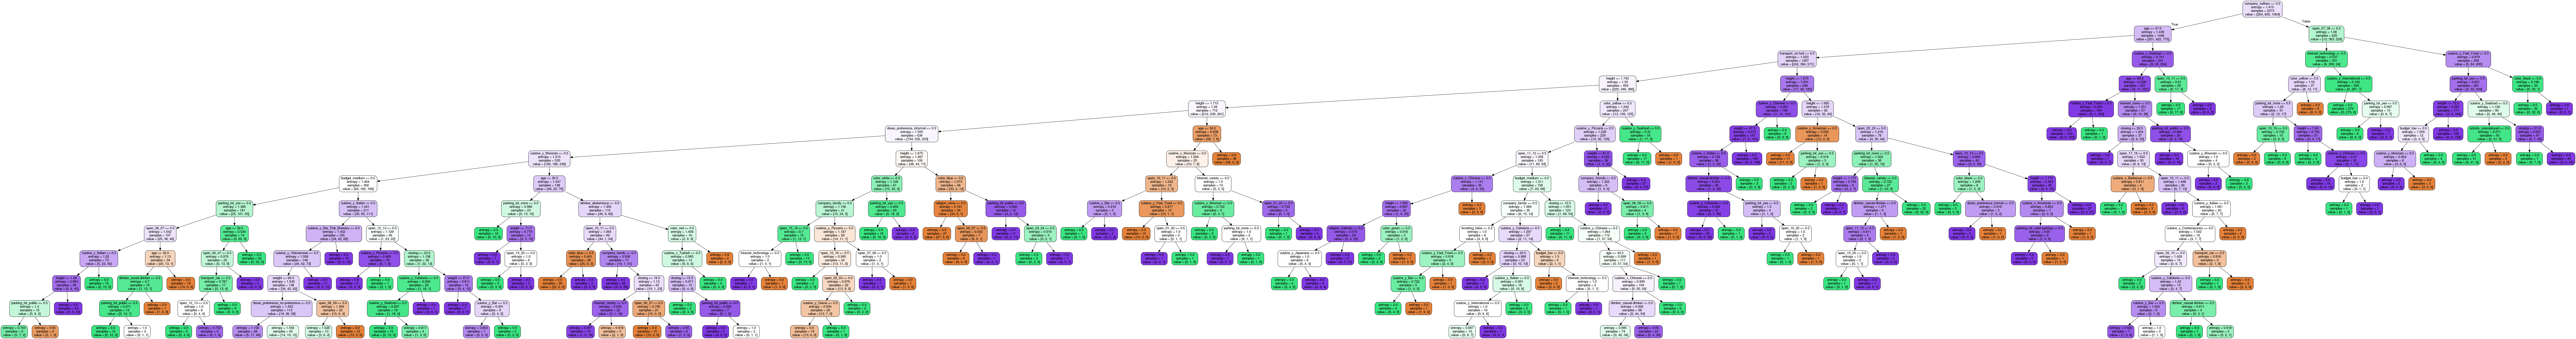

In [7]:
## Basically, after max_depth = 13 nothing better happens

random_state= np.random.randint(low=0, high=1e5)

clf = tree.DecisionTreeClassifier(max_depth=13, criterion='entropy', splitter='best', random_state=random_state)
clf = clf.fit(x_train, y_train)

output = clf.predict(x_val)
target = y_val
accuracy =sum(output == target)/ len(target)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

feature_names = list(data.columns)[:-1]
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,filled=True, rounded=True)
graph = graphviz.Source(dot_data)  
png_bytes = graph.pipe(format='png')
with open('dtree_pipe1.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

Accuracy on validation set: 86.15 %


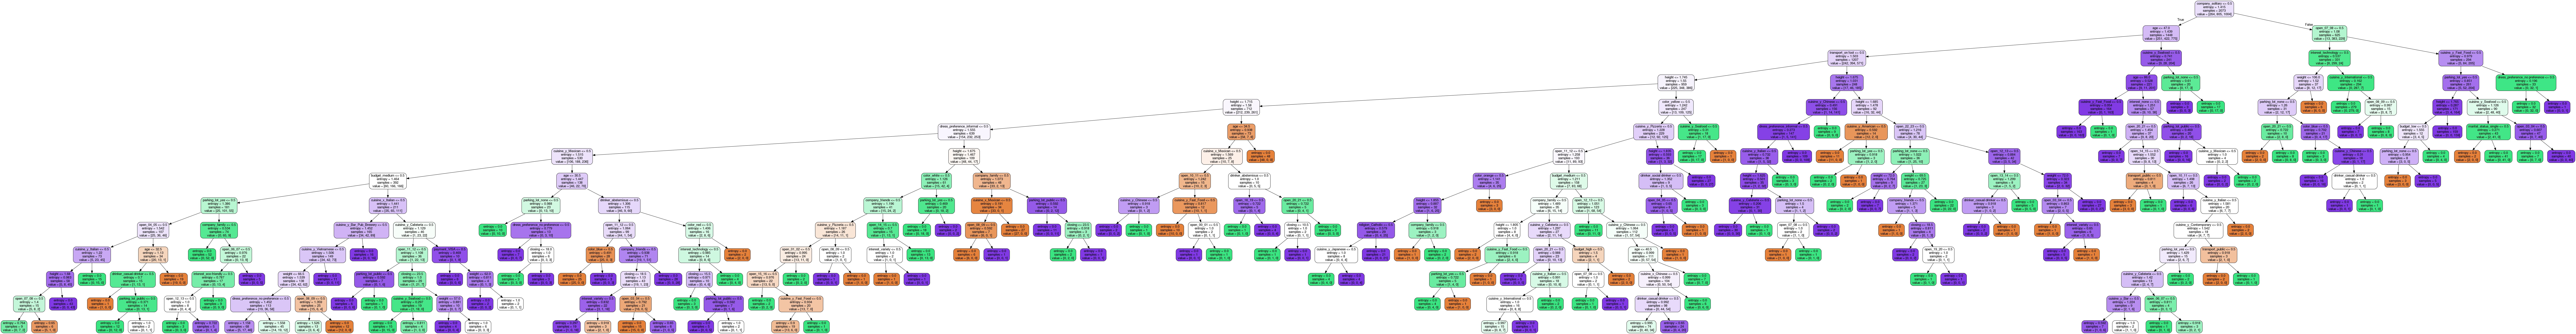

In [8]:
## Basically, after max_depth = 13 nothing better happens

random_state= np.random.randint(low=0, high=1e5)
clf = tree.DecisionTreeClassifier(max_depth=13, criterion='entropy', splitter='best', random_state=random_state)
clf = clf.fit(x_train, y_train)

output = clf.predict(x_val)
target = y_val
accuracy =sum(output == target)/ len(target)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

feature_names = list(data.columns)[:-1]
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_names,filled=True, rounded=True)
graph = graphviz.Source(dot_data)  
png_bytes = graph.pipe(format='png')
with open('dtree_pipe2.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

## START WITH ENSEMBLING METHODS

In [9]:
from sklearn.metrics import accuracy_score


In [10]:
def create_bootstrap_data():
    bootstrap_ids = np.random.randint(0, len(x_train), size=len(x_train))
    return x_train[bootstrap_ids,:], y_train[bootstrap_ids]

In [11]:
def build_classifier(data_set, labels, max_depth):
    random_state= np.random.randint(low=0, high=1e5)
    decision_tree = tree.DecisionTreeClassifier(max_depth = max_depth, min_samples_split=3, min_samples_leaf=2, random_state=random_state)
    decision_tree.fit(data_set, labels)
    return decision_tree

In [12]:
def build_classifiers(cases, max_depth):
    classifiers = []
    for case in range(cases):
        bootstrap_set, bootstrap_labels = create_bootstrap_data()
        classifier = build_classifier(bootstrap_set, bootstrap_labels, max_depth)
        classifiers.append(classifier)
    return classifiers

In [13]:
def vote(classifiers, test_data):
    output = []
    for classifier in classifiers:
        output.append(classifier.predict(test_data))
    output = np.array(output)
    predicted = []
    for i in range(len(test_data)):
        classified = output[:, i]
        counts = np.bincount(classified)
        predicted.append(np.argmax(counts))
    return predicted

## Grid search:

In [14]:
m_arr = np.arange(10, 80, 10)
depth_arr = np.linspace(4, 15, 12)

for m in m_arr:
    for max_depth in depth_arr:
        classifiers = build_classifiers(m, max_depth)
        predicted = vote(classifiers, x_val)
        accuracy = accuracy_score(y_val, predicted)
        print("Accuracy on validation set: {:.2f} using m={:} and depth = {:}".format(accuracy*100, m, max_depth))

Accuracy on validation set: 71.11 using m=10 and depth = 4.0
Accuracy on validation set: 74.49 using m=10 and depth = 5.0
Accuracy on validation set: 78.38 using m=10 and depth = 6.0
Accuracy on validation set: 79.39 using m=10 and depth = 7.0
Accuracy on validation set: 83.78 using m=10 and depth = 8.0
Accuracy on validation set: 84.80 using m=10 and depth = 9.0
Accuracy on validation set: 87.67 using m=10 and depth = 10.0
Accuracy on validation set: 87.33 using m=10 and depth = 11.0
Accuracy on validation set: 86.66 using m=10 and depth = 12.0
Accuracy on validation set: 88.51 using m=10 and depth = 13.0
Accuracy on validation set: 91.39 using m=10 and depth = 14.0
Accuracy on validation set: 90.20 using m=10 and depth = 15.0
Accuracy on validation set: 72.80 using m=20 and depth = 4.0
Accuracy on validation set: 77.03 using m=20 and depth = 5.0
Accuracy on validation set: 79.90 using m=20 and depth = 6.0
Accuracy on validation set: 83.61 using m=20 and depth = 7.0
Accuracy on valida

In [18]:
m = 100
max_depth = 13
classifiers = build_classifiers(m, max_depth)
predicted = vote(classifiers, x_val)
accuracy = accuracy_score(y_val, predicted)
print("Accuracy on validation set: {:.2f} %".format(accuracy*100))

Accuracy on validation set: 90.03 %


In [16]:
STOP

NameError: name 'STOP' is not defined

# More esemble methods

In [20]:
import numpy as np
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import itertools as it

import warnings
warnings.filterwarnings('ignore')

In [21]:
def build_classifiers(data_set, labels): 
      
    neighbors = KNeighborsClassifier()
    neighbors.fit(data_set, labels)

    linear_regression = LinearRegression()
    linear_regression.fit(data_set, labels)

    qda = QuadraticDiscriminantAnalysis()
    qda.fit(data_set, labels)
    
    gauss = GaussianNB()
    gauss.fit(data_set, labels)

    svc = SVC()
    svc.fit(data_set, labels)

    return neighbors, linear_regression, qda, gauss, svc

In [35]:
def build_stacked_classifier(classifiers, data_set, labels, test_data_set, test_labels): 
    output = [] 
    classifiers_list = []
    
    classifiers_combinations = it.combinations(classifiers, 3)
    
    
    for model in classifiers_combinations:
        tmp_output = []
        tmp_model = []
        for classifier in model:
            tmp_output.append(classifier.predict(data_set)) 
            tmp_model.append(classifier)
        tmp_output = np.array(tmp_output).reshape((2073,3))
        
        output.append(tmp_output)  # ten set of data, for each of 10 combination 3-elements from 5 elements set
        classifiers_list.append(tmp_model)
        
    model_fit = []
    for model_output in output:
        stacked_classifier = DecisionTreeClassifier()
        model_fit.append(stacked_classifier.fit(model_output.reshape((2073,3)),  labels.reshape(2073,)))
 

    test_predictions_list = []   
    for i in range(len(model_fit)):
        classifiers = classifiers_list[i]
        stacked_classifier = model_fit[i]
        test_set = []
        
        for classifier in classifiers:
            test_set.append(classifier.predict(test_data_set))
        test_set = np.array(test_set).reshape((len(test_set[0]),3))
        predicted = stacked_classifier.predict(test_set)
        test_predictions_list.append(predicted)
    
    accuracy_list = []
    for prediction in test_predictions_list:
        accuracy_list.append(accuracy_score(test_labels, prediction))
        accuracy = accuracy_score(test_labels, prediction) ##
        #print(accuracy)
    
    best_prediction_index = np.argmax(accuracy_list)
    
    best_classifiers = classifiers_list[best_prediction_index]
    best_stacked_classifier = model_fit[best_prediction_index]
    best_predicted = best_stacked_classifier.predict(test_set)
    
    return best_classifiers, best_predicted


In [36]:
raw_list = [KNeighborsClassifier(),LinearRegression(), QuadraticDiscriminantAnalysis(),GaussianNB(),SVC()]  

classifiers = build_classifiers(x_train, y_train)
best_classifiers, predicted = build_stacked_classifier(classifiers,x_train, y_train, x_val, y_val)
accuracy = accuracy_score(y_train, predicted)
print("\nBest set of classifiers:", best_classifiers)
print("\nBest accuracy:",accuracy)



ValueError: Found input variables with inconsistent numbers of samples: [2073, 592]